In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [38]:
device = 'cuda'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [30]:
trainset = torchvision.datasets.SVHN(root='./svhn-dataset', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./svhn-dataset', split='test', download=True, transform=transform)

Using downloaded and verified file: /kaggle/input/svhn-dataset/train_32x32.mat
Using downloaded and verified file: /kaggle/input/svhn-dataset/test_32x32.mat


In [31]:
len(trainset)

73257

In [32]:
from torch.utils.data import random_split

val_size = 7000
train_size = len(trainset) - val_size

# Разделение данных
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

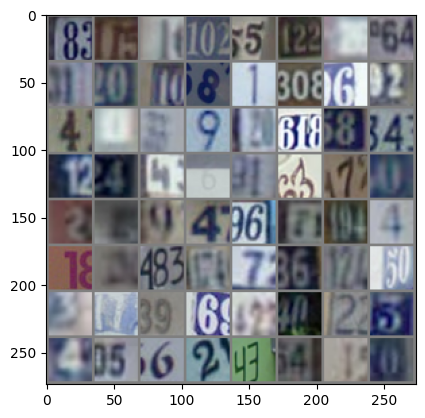

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Получение нескольких случайных изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Показать изображения
imshow(torchvision.utils.make_grid(images))

In [13]:
# Ground truth labels для первой строчки
print(' '.join('%5s' % labels[j].item() for j in range(8)))

    8     1     1     0     5     2     2     6


In [39]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(FullyConnectedLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weights.t() + self.bias

class ReluLayer(nn.Module):
    def __init__(self):
        super(ReluLayer, self).__init__()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(x)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = FullyConnectedLayer(3*32*32, 128)
        self.relu1 = ReluLayer()
        self.fc2 = FullyConnectedLayer(128, 64)
        self.relu2 = ReluLayer()
        self.fc3 = FullyConnectedLayer(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

class SimpleNNBatchNorm(nn.Module):
    def __init__(self):
        super(SimpleNNBatchNorm, self).__init__()
        self.fc1 = FullyConnectedLayer(3*32*32, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.fc2 = FullyConnectedLayer(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.fc3 = FullyConnectedLayer(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            
            grad = param.grad.data
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * param.data
            
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * grad
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (grad ** 2)
            
            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)
            
            param.data = param.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()


def get_optimizer(name, params, lr):
    if name == 'adam':
        return AdamOptimizer(params, lr=lr)
    elif name == 'momentum':
        return optim.SGD(params, lr=lr, momentum=0.9)
    elif name == 'rmsprop':
        return optim.RMSprop(params, lr=lr)
    else:
        raise ValueError("Unknown optimizer: {}".format(name))

In [35]:
def validate_gradients(model, inputs, targets, criterion, delta=1e-5):
    inputs = inputs.view(-1, 3*32*32).to(device)
    targets = targets.to(device)
    model.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()

    param_list = [param for param in model.parameters() if param.requires_grad]
    total_params = sum(p.numel() for p in param_list)
    num_checks = 15
    if num_checks > total_params:
        num_checks = total_params

    selected_indices = torch.randperm(total_params)[:num_checks]

    for param in param_list:
        print(f"Validating gradient for parameter: {param.shape}")
        param_data_flat = param.data.view(-1)
        param_grad_flat = param.grad.view(-1)

        for idx in selected_indices:
            if idx >= param_data_flat.size(0):
                break

            original_value = param_data_flat[idx].item()
            param_data_flat[idx] = original_value + delta
            loss_plus = criterion(model(inputs), targets).item()
            param_data_flat[idx] = original_value - delta
            loss_minus = criterion(model(inputs), targets).item()
            param_data_flat[idx] = original_value

            estimated_grad = (loss_plus - loss_minus) / (2 * delta)
            actual_grad = param_grad_flat[idx].item()

            if abs(estimated_grad - actual_grad) > delta:
                print(f'Gradient check failed for parameter at index {idx}')
                return False

    print('All gradients are correct!')
    return True


In [33]:
def train_model(model, trainloader, valloader, criterion, optimizer, epochs=10):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        

        train_loss.append(running_loss/len(trainloader))
        
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/len(valloader))
        
        validate_gradients(model, *next(iter(trainloader)), criterion)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")
    
    return train_loss, val_loss

Training SimpleNN with learning rate 0.001 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.3529297263005526, Val Loss: 1.0171271920204163
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 0.8935881948321482, Val Loss: 0.8138818166472696
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient f

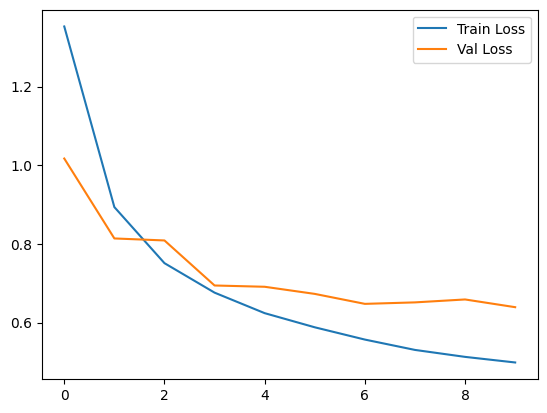

Training SimpleNN with learning rate 0.001 and optimizer rmsprop
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.3148299082826003, Val Loss: 1.1352284724062138
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 0.9280174242541136, Val Loss: 1.102931680462577
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient

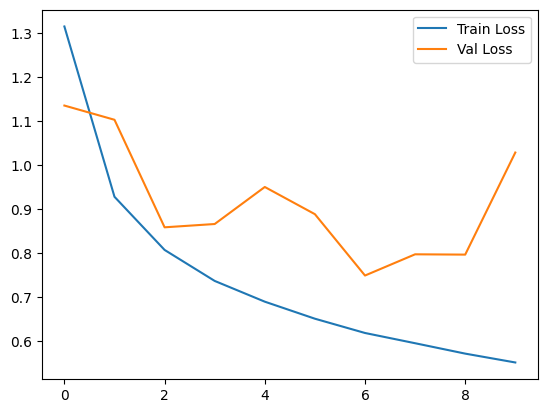

Training SimpleNN with learning rate 0.001 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.2619615882980315, Val Loss: 2.2404767925089057
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 2.2383700452716195, Val Loss: 2.234847279028459
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradien

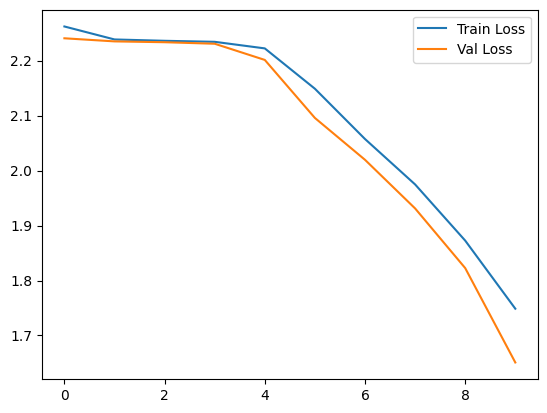

Training SimpleNN with learning rate 0.01 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.2150622055107103, Val Loss: 2.211243223060261
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 2.1992990558672134, Val Loss: 2.252944499796087
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for 

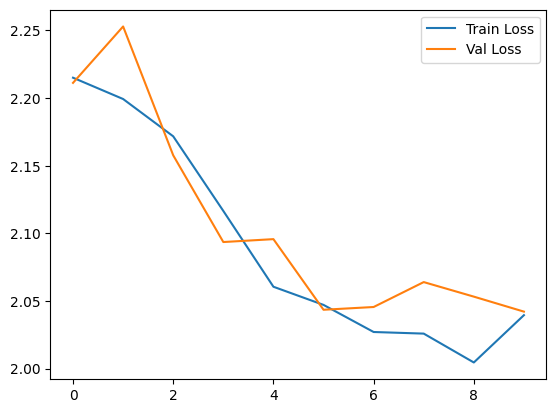

Training SimpleNN with learning rate 0.01 and optimizer rmsprop
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.7752538079460614, Val Loss: 2.2355778932571413
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 2.237634184968057, Val Loss: 2.2356903553009033
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient 

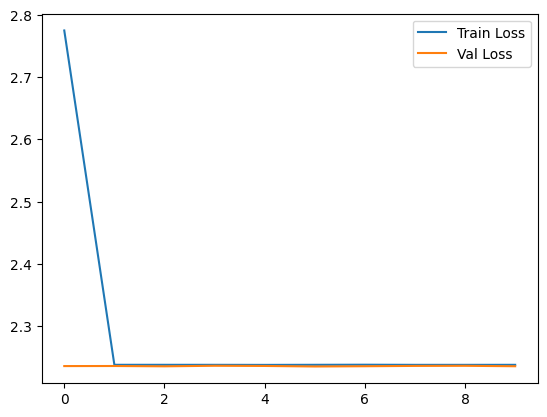

Training SimpleNN with learning rate 0.01 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.145284785036875, Val Loss: 1.848353846506639
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 1.3777332579767383, Val Loss: 1.1160016363317316
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient 

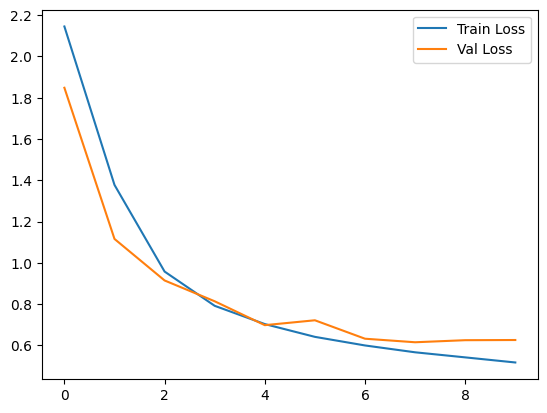

Training SimpleNN with learning rate 0.001 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.3964858959540436, Val Loss: 1.0214141433889217
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 0.8868714381714125, Val Loss: 0.8929647437550805
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient f

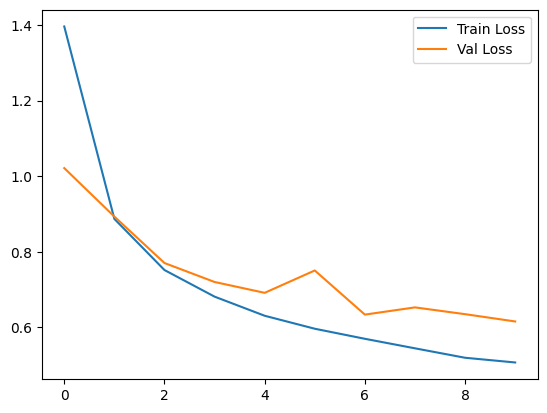

Training SimpleNN with learning rate 0.001 and optimizer rmsprop
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.364496262434827, Val Loss: 1.168153417110443
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 0.9527576699507743, Val Loss: 0.9741762285882777
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient 

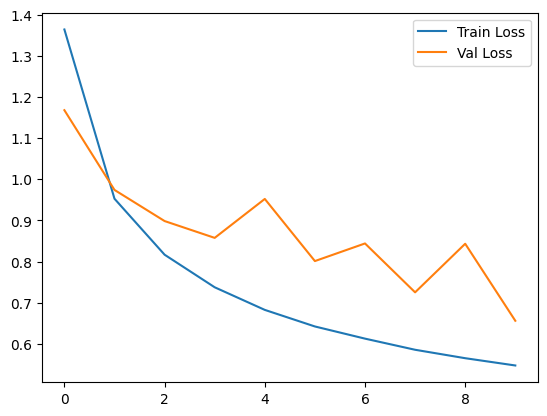

Training SimpleNN with learning rate 0.001 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.2616593306129045, Val Loss: 2.2414200587706135
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 2.2382147206302774, Val Loss: 2.235480440746654
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradien

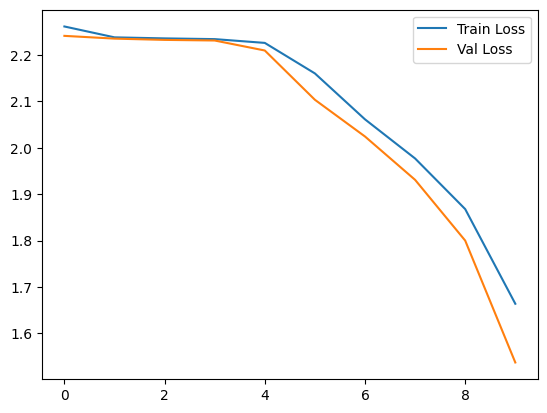

Training SimpleNN with learning rate 0.01 and optimizer adam
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.2365172509981397, Val Loss: 2.23401921228929
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 2.236124844854863, Val Loss: 2.2361529567024925
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for p

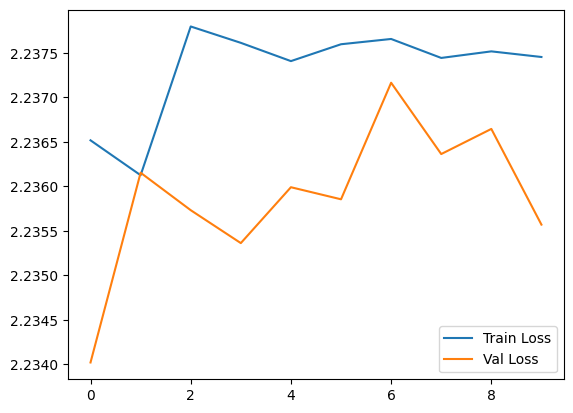

Training SimpleNN with learning rate 0.01 and optimizer rmsprop
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 3.0412170580915503, Val Loss: 1.91077007597143
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 1.8145486942589513, Val Loss: 1.6766888119957664
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient f

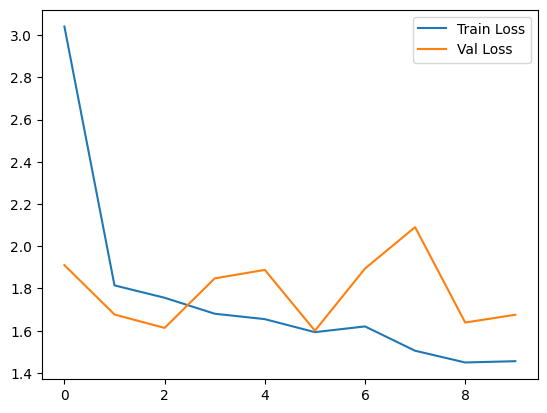

Training SimpleNN with learning rate 0.01 and optimizer momentum
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 2.141222098964522, Val Loss: 1.8810111544348977
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 1.3714698228021387, Val Loss: 1.1049740905111487
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient

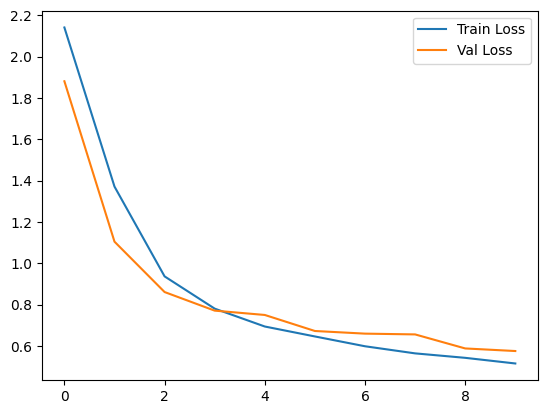

In [43]:
from itertools import product

models = [SimpleNN(), SimpleNNBatchNorm()]
lrs = [0.001, 0.01]
optimizers = ['adam', 'rmsprop', 'momentum']
results = []

for model, lr, optimizer_name in product(models, lrs, optimizers):
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    
    print(f"Training {model.__class__.__name__} with learning rate {lr} and optimizer {optimizer_name}")
    train_loss, val_loss = train_model(model, trainloader, valloader, criterion, optimizer)
    result = dict()
    result['train_loss'] = train_loss
    result['val_loss'] = val_loss
    result['model'] = model.__class__.__name__
    result['optimizer'] = optimizer_name
    result['lr'] = lr
    
    results.append(result)
    
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.show()

In [48]:
min_val_loss = 10
for res in results:
    if res['val_loss'][-1] < min_val_loss:
        min_val_loss = res['val_loss'][-1]
        
for res in results:
    if res['val_loss'][-1] == min_val_loss:
        print(f'Best combination of params is: Model - {res["model"]}, optimizer - {res["optimizer"]}, lr - {res["lr"]}')
        print(f'Best validation loss after 10 epochs - {min_val_loss}')
        break

Best combination of params is: Model - SimpleNN, optimizer - momentum, lr - 0.01
Best validation loss after 10 epochs - 0.5758602480996738


In [51]:
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = get_optimizer('momentum', model.parameters(), lr=0.01)

train_loss, val_loss = train_model(model, trainloader, valloader, criterion, optimizer, epochs=20)

Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/20, Train Loss: 2.1202420377132976, Val Loss: 1.8636841828172857
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([64, 128])
Validating gradient for parameter: torch.Size([64])
Validating gradient for parameter: torch.Size([10, 64])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/20, Train Loss: 1.373821128461812, Val Loss: 1.08669501488859
Validating gradient for parameter: torch.Size([128, 3072])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter

In [52]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Accuracy of the model on test images: {100 * correct / total}%")

evaluate_model(model, testloader)

Accuracy of the model on test images: 81.66103257529196%


### Выводы

Лучше всего показала себя такая связка параметров - Model - SimpleNN, optimizer - momentum, lr - 0.01.
После обучения такой модели на 20 эпохах, на тестовой выборке точность модели оказалась 81.6%, что я считаю довольно хорошим результатом для 20 эпох обучения